# Elastic wave equation implementation on a staggered grid

This is a first attempt at implemenenting the elastic wave equation as described in:

[1] Jean Virieux (1986). ”P-SV wave propagation in heterogeneous media: Velocity‐stress finite‐difference method.” GEOPHYSICS, 51(4), 889-901. https://doi.org/10.1190/1.1442147

The current version actually attempts to mirror the FDELMODC implementation by Jan Thorbecke:

[2] https://janth.home.xs4all.nl/Software/fdelmodcManual.pdf

## Explosive source

We will first attempt to replicate the explosive source test case described in [1], Figure 4. We start by defining the source signature $g(t)$, the derivative of a Gaussian pulse, given by Eq 4:

$$g(t) = -2 \alpha(t - t_0)e^{-\alpha(t-t_0)^2}$$

In [1]:
from devito import *
from examples.seismic.source import WaveletSource, RickerSource, GaborSource, TimeAxis
from examples.seismic import plot_image
import numpy as np

from sympy import init_printing, latex
init_printing(use_latex=True)

In [2]:
# Initial grid: 1km x 1km, with spacing 100m
extent = (1500., 1500.)
shape = (201, 201)
x = SpaceDimension(name='x', spacing=Constant(name='h_x', value=extent[0]/(shape[0]-1)))
z = SpaceDimension(name='z', spacing=Constant(name='h_z', value=extent[1]/(shape[1]-1)))
grid = Grid(extent=extent, shape=shape, dimensions=(x, z))

In [3]:
class DGaussSource(WaveletSource):
    
    def wavelet(self, f0, t):
        a = 0.004
        return -2.*a*(t - 1/f0) * np.exp(-a * (t - 1/f0)**2)

# Timestep size from Eq. 7 with V_p=6000. and dx=100
t0, tn = 0., 300.
dt = (10. / np.sqrt(2.)) / 6.
time_range = TimeAxis(start=t0, stop=tn, step=dt)

src = RickerSource(name='src', grid=grid, f0=0.01, time_range=time_range)
src.coordinates.data[:] = [750., 750.]

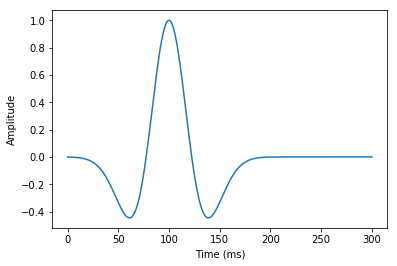

In [4]:
#NBVAL_SKIP

src.show()

In [5]:
# Now we create the velocity and pressure fields
so = 2

v = VectorTimeFunction(name='v', grid=grid, space_order=so, time_order=1)
tau = TensorTimeFunction(name='t', grid=grid, space_order=so, time_order=1)

In [6]:
# Now let's try and create the staggered updates
t = grid.stepping_dim
time = grid.time_dim

# We need some initial conditions
V_p = 2.0
V_s = 1.0
density = 1.8

# The source injection term
src_xx = src.inject(field=tau.forward[0,0], expr=src)
src_zz = src.inject(field=tau.forward[1,1], expr=src)

# Thorbecke's parameter notation
cp2 = V_p*V_p
cs2 = V_s*V_s
ro = 1/density

mu = cs2*density
l = (cp2*density - 2*mu)

# fdelmodc reference implementation
u_v = Eq(v.forward, v + dt*ro*div(tau))
u_t = Eq(tau.forward, tau + dt * l * diag(div(v.forward)) + dt * mu * (grad(v.forward) + grad(v.forward).T))

op = Operator([u_v] + src_xx + src_zz + [u_t])

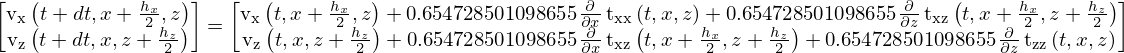

In [7]:
u_v

In [8]:
#NBVAL_IGNORE_OUTPUT

op()

Operator `Kernel` run in 0.03 s


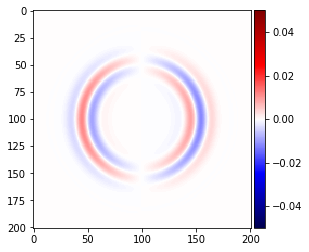

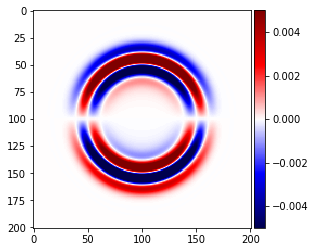

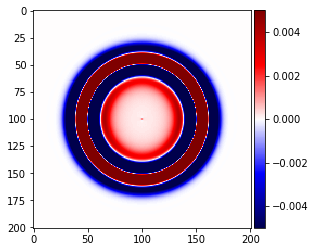

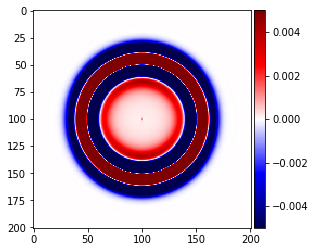

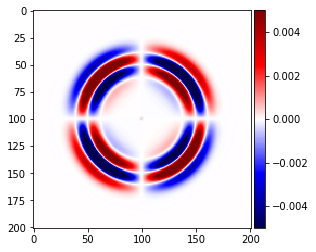

In [9]:
#NBVAL_SKIP

# Let's see what we got....
plot_image(v[0].data[0], vmin=-.5*1e-1, vmax=.5*1e-1, cmap="seismic")
plot_image(v[1].data[0], vmin=-.5*1e-2, vmax=.5*1e-2, cmap="seismic")
plot_image(tau[0, 0].data[0], vmin=-.5*1e-2, vmax=.5*1e-2, cmap="seismic")
plot_image(tau[1,1].data[0], vmin=-.5*1e-2, vmax=.5*1e-2, cmap="seismic")
plot_image(tau[0,1].data[0], vmin=-.5*1e-2, vmax=.5*1e-2, cmap="seismic")

In [10]:
#NBVAL_IGNORE_OUTPUT

assert np.isclose(norm(v[0]), 0.6252589, atol=1e-4, rtol=0)

In [11]:
# Now that looks pretty! But let's do it again with a higher order...
so = 12
v = VectorTimeFunction(name='v', grid=grid, space_order=so, time_order=1)
tau = TensorTimeFunction(name='t', grid=grid, space_order=so, time_order=1)
# The source injection term
src_xx = src.inject(field=tau.forward[0,0], expr=src)
src_zz = src.inject(field=tau.forward[1,1], expr=src)
# fdelmodc reference implementation
u_v = Eq(v.forward, v + dt*ro*div(tau))
u_t = Eq(tau.forward, tau + l * diag(div(v.forward)) + mu * (grad(v.forward) + grad(v.forward).T))

op = Operator([u_v] + src_xx + src_zz + [u_t])


In [12]:
#NBVAL_IGNORE_OUTPUT
v[0].data.fill(0.)
v[1].data.fill(0.)
tau[0,0].data.fill(0.)
tau[0,1].data.fill(0.)
tau[1,1].data.fill(0.)

op()

Operator `Kernel` run in 0.08 s


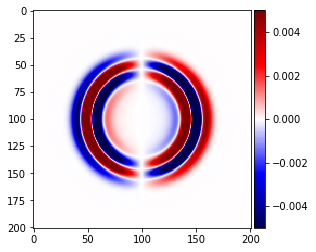

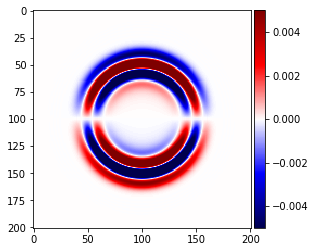

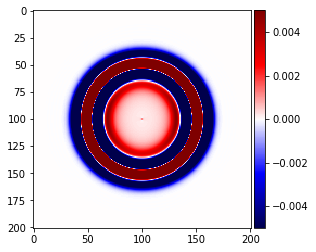

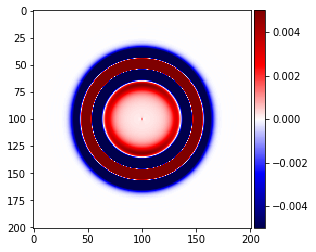

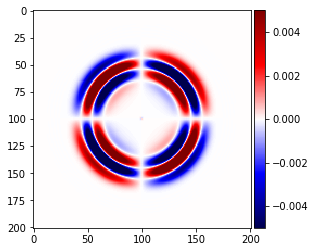

In [13]:
#NBVAL_SKIP

# Let's see what we got....
plot_image(v[0].data[0], vmin=-.5*1e-2, vmax=.5*1e-2, cmap="seismic")
plot_image(v[1].data[0], vmin=-.5*1e-2, vmax=.5*1e-2, cmap="seismic")
plot_image(tau[0, 0].data[0], vmin=-.5*1e-2, vmax=.5*1e-2, cmap="seismic")
plot_image(tau[1,1].data[0], vmin=-.5*1e-2, vmax=.5*1e-2, cmap="seismic")
plot_image(tau[0,1].data[0], vmin=-.5*1e-2, vmax=.5*1e-2, cmap="seismic")

In [14]:
#NBVAL_IGNORE_OUTPUT

assert np.isclose(norm(v[0]), 0.73681911, atol=1e-4, rtol=0)